<a href="https://colab.research.google.com/github/TirmidziOthman/Gold-Stock-Market-Prediction-Using-LSTM/blob/main/lstm_model2_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from keras.callbacks import EarlyStopping
import itertools
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr

yf.pdr_override()

# For time stamps
from datetime import datetime

In [ ]:
# Get the stock quote
df = pdr.get_data_yahoo('GOLD', start='2012-01-01', end=datetime.now())
# Show teh data
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,46.270000,47.770000,46.200001,47.509998,38.322601,9010200
2012-01-04,47.480000,48.490002,47.330002,48.220001,38.895298,8905400
2012-01-05,47.720001,48.520000,47.419998,48.020000,38.733978,5800800
2012-01-06,48.299999,48.299999,47.270000,47.540001,38.346806,4527100
2012-01-09,47.720001,48.029999,47.250000,47.709999,38.483925,3958600
...,...,...,...,...,...,...
2023-12-05,17.410000,17.520000,17.230000,17.420000,17.420000,16180500
2023-12-06,17.510000,17.639999,17.340000,17.360001,17.360001,12854100
2023-12-07,17.420000,17.459999,17.110001,17.219999,17.219999,14132100


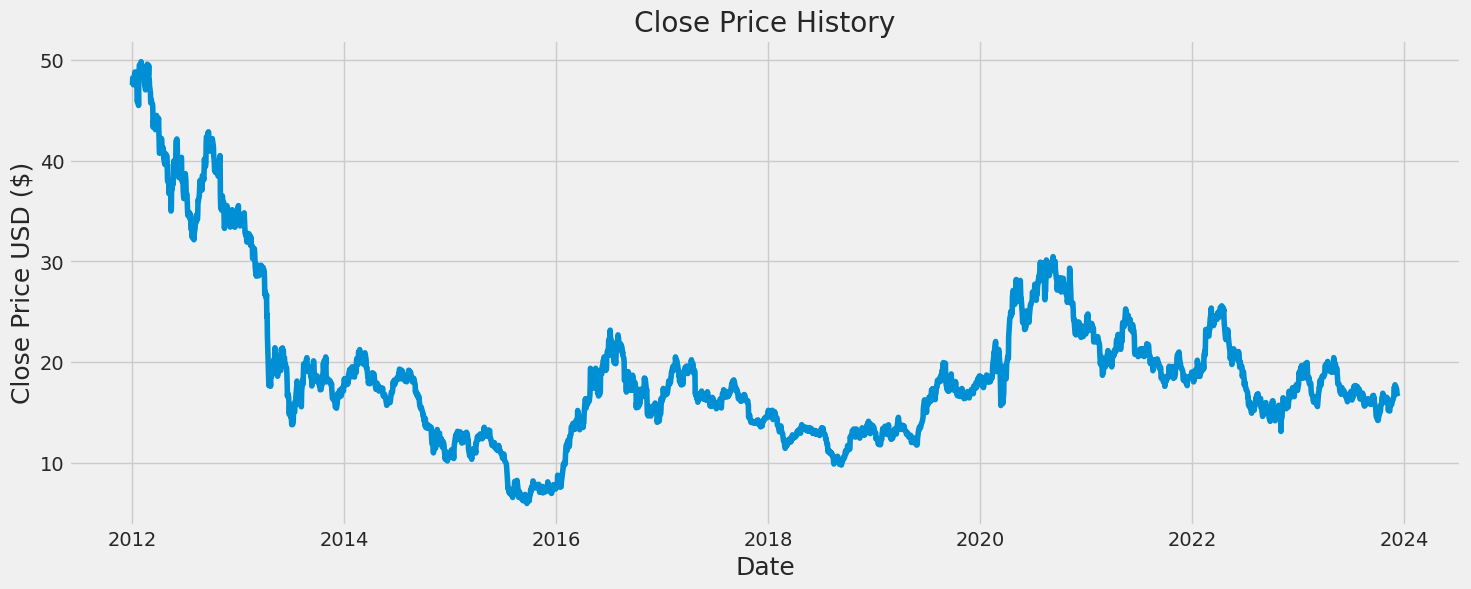

In [ ]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [ ]:
# Create a new dataframe with only the 'Close column
data = df.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .80 ))

training_data_len

2404

In [ ]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.9471405 ],
       [0.96331737],
       [0.95876051],
       ...,
       [0.25700612],
       [0.24720894],
       [0.24253813]])

In [ ]:
# Create the training data set
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[array([0.9471405 , 0.96331737, 0.95876051, 0.94782409, 0.95169736,
       0.96582365, 0.97584868, 0.97676007, 0.96605146, 0.95830481,
       0.95716562, 0.92321707, 0.90886307, 0.93438139, 0.90088854,
       0.96764634, 0.97789927, 0.99270897, 0.98519021, 0.98701291,
       0.98701291, 1.        , 0.98268393, 0.98496232, 0.9874686 ,
       0.98268393, 0.98108905, 0.96172248, 0.95898831, 0.94941898,
       0.94531781, 0.96217809, 0.93620408, 0.96855773, 0.99111408,
       0.99430394, 0.97789927, 0.96992473, 0.99156977, 0.95215306,
       0.9592162 , 0.94508992, 0.93005233, 0.9065846 , 0.90817948,
       0.91387554, 0.90840738, 0.90430621, 0.89792656, 0.8516746 ,
       0.86375021, 0.86602869, 0.85896555, 0.86238322, 0.85873774,
       0.84620643, 0.86169963, 0.8783322 , 0.86261102, 0.84780132])]
[0.8473456256059263]

[array([0.9471405 , 0.96331737, 0.95876051, 0.94782409, 0.95169736,
       0.96582365, 0.97584868, 0.97676007, 0.96605146, 0.95830481,
       0.95716562, 0.92321707, 0.908

In [ ]:
y_true = dataset[training_data_len:, :]

In [ ]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = scaled_data[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

In [ ]:
def LSTM_HyperParameter_Tuning(config, x_train, y_train, x_test, y_test):
    n_neurons1, n_neurons2, n_batch_size, dropout = config
    possible_combinations = list(itertools.product(n_neurons1,n_neurons2, n_batch_size, dropout))

    print(possible_combinations)
    print('\n')

    hist = []

    for i in range(0, len(possible_combinations)):

        print(f'{i+1}th combination: \n')
        print('--------------------------------------------------------------------')

        n_neurons1, n_neurons2, n_batch_size, dropout = possible_combinations[i]

        # instantiating the model in the strategy scope creates the model on the TPU
        #with tpu_strategy.scope():
        regressor = Sequential()
        regressor.add(LSTM(units=n_neurons1, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
        regressor.add(Dropout(dropout))
        regressor.add(LSTM(units=n_neurons2, return_sequences=False))
        regressor.add(Dropout(dropout))
        regressor.add(Dense(units=1, activation='linear'))
        regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        '''''
        From the mentioned article above --> If a validation dataset is specified to the fit() function via the validation_data or v
        alidation_split arguments,then the loss on the validation dataset will be made available via the name “val_loss.”
        '''''

        file_path = 'best_model.h5'

        mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

        '''''
        cb = Callback(...)  # First, callbacks must be instantiated.
        cb_list = [cb, ...]  # Then, one or more callbacks that you intend to use must be added to a Python list.
        model.fit(..., callbacks=cb_list)  # Finally, the list of callbacks is provided to the callback argument when fitting the model.
        '''''

        regressor.fit(x_train, y_train, validation_split=0.3, epochs=40, batch_size=n_batch_size, callbacks=[es, mc], verbose=0)

        # load the best model
        # regressor = load_model('best_model.h5')

        train_accuracy = regressor.evaluate(x_train, y_train, verbose=0)
        test_accuracy = regressor.evaluate(x_test, y_test, verbose=0)

        hist.append(list((n_neurons1,n_neurons2, n_batch_size, dropout, train_accuracy, test_accuracy)))

        print(f'{str(i)}-th combination = {possible_combinations[i]} \n train accuracy: {train_accuracy} and test accuracy: {test_accuracy}')

        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')

    return hist

In [ ]:
config = [[64], [32, 64], [64], [ 0.3, 0.4, 0.5 ]]

# list of lists --> [[n_neurons1], [n_neurons2], [n_batch_size], [dropout]]

hist = LSTM_HyperParameter_Tuning(config, x_train, y_train, x_test, y_test)  # change x_train shape

[(64, 32, 64, 0.3), (64, 32, 64, 0.4), (64, 32, 64, 0.5), (64, 64, 64, 0.3), (64, 64, 64, 0.4), (64, 64, 64, 0.5)]


1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 0.00116, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss did not improve from 0.00116

Epoch 3: val_loss improved from 0.00116 to 0.00111, saving model to best_model.h5

Epoch 4: val_loss improved from 0.00111 to 0.00089, saving model to best_model.h5

Epoch 5: val_loss improved from 0.00089 to 0.00080, saving model to best_model.h5

Epoch 6: val_loss improved from 0.00080 to 0.00078, saving model to best_model.h5

Epoch 7: val_loss did not improve from 0.00078

Epoch 8: val_loss improved from 0.00078 to 0.00069, saving model to best_model.h5

Epoch 9: val_loss did not improve from 0.00069

Epoch 10: val_loss did not improve from 0.00069

Epoch 11: val_loss did not improve from 0.00069

Epoch 12: val_loss improved from 0.00069 to 0.00062, saving model to best_model.h5

Epoch 13: val_loss did not improve from 0.00062

Epoch 14: val_loss did not improve from 0.00062

Epoch 15: val_loss improved from 0.00062 to 0.00059, saving model to best_model.h5

Epoch 16: val_loss did not improve from 0.00059

Epoch 17: val_loss did not 

In [ ]:
hist = pd.DataFrame(hist)
hist.set_axis(['neurons_1','neurons_2', 'Batch_size', 'Dropout','train_accuracy', 'test_accuracy'], axis='columns', inplace=True)
hist = hist.sort_values(by=['test_accuracy'], ascending=True)
hist

<ipython-input-10-5e55de15dbc9>:2: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  hist.set_axis(['neurons_1','neurons_2', 'Batch_size', 'Dropout','train_accuracy', 'test_accuracy'], axis='columns', inplace=True)


,neurons_1,neurons_2,Batch_size,Dropout,train_accuracy,test_accuracy
3,64,64,64,0.3,"[0.00040735630318522453, 0.02018306963145733]","[0.0002537537075113505, 0.015929648652672768]"
4,64,64,64,0.4,"[0.0006590810953639448, 0.02567257545888424]","[0.0004724204773083329, 0.021735236048698425]"
0,64,32,64,0.3,"[0.0006967668305151165, 0.026396341621875763]","[0.00047416481538675725, 0.021775325760245323]"
1,64,32,64,0.4,"[0.0007352944812737405, 0.027116313576698303]","[0.0004745592304971069, 0.021784380078315735]"
5,64,64,64,0.5,"[0.000782544375397265, 0.027973994612693787]","[0.0005585370818153024, 0.023633388802409172]"
2,64,32,64,0.5,"[0.001092348131351173, 0.03305068984627724]","[0.0007690325146540999, 0.027731435373425484]"


In [ ]:
hist.to_csv('hyperparameter_model1.csv')

In [ ]:
hyper_1 = pd.read_csv('/content/hyperparameter_model1.csv')
hyper_1

,Unnamed: 0,neurons_1,neurons_2,Batch_size,Dropout,train_accuracy,test_accuracy
0,3,64,64,64,0.3,"[0.00040735630318522453, 0.02018306963145733]","[0.0002537537075113505, 0.015929648652672768]"
1,4,64,64,64,0.4,"[0.0006590810953639448, 0.02567257545888424]","[0.0004724204773083329, 0.021735236048698425]"
2,0,64,32,64,0.3,"[0.0006967668305151165, 0.026396341621875763]","[0.00047416481538675725, 0.021775325760245323]"
3,1,64,32,64,0.4,"[0.0007352944812737405, 0.027116313576698303]","[0.0004745592304971069, 0.021784380078315735]"
4,5,64,64,64,0.5,"[0.000782544375397265, 0.027973994612693787]","[0.0005585370818153024, 0.023633388802409172]"
5,2,64,32,64,0.5,"[0.001092348131351173, 0.03305068984627724]","[0.0007690325146540999, 0.027731435373425484]"


In [ ]:
list(hyper_1.values[0][1:5])

[64, 64, 64, 0.3]

In [ ]:
n_neurons1, n_neurons2, n_batch_size, dropout = list(hyper_1.values[0][1:5])

In [ ]:
regressor = Sequential()
regressor.add(LSTM(units=n_neurons1, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
regressor.add(Dropout(dropout))
regressor.add(LSTM(units=n_neurons2, return_sequences=False))
regressor.add(Dropout(dropout))
regressor.add(Dense(units=25))
regressor.add(Dense(units=1, activation='linear'))
regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

file_path = 'best_model.h5'

mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history2 = regressor.fit(x_train, y_train, validation_split=0.3, epochs=40, batch_size=n_batch_size, callbacks=[es, mc], verbose=0)


Epoch 1: val_loss improved from inf to 0.00078, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 0.00078 to 0.00074, saving model to best_model.h5

Epoch 3: val_loss improved from 0.00074 to 0.00067, saving model to best_model.h5

Epoch 4: val_loss did not improve from 0.00067

Epoch 5: val_loss did not improve from 0.00067

Epoch 6: val_loss did not improve from 0.00067

Epoch 7: val_loss improved from 0.00067 to 0.00062, saving model to best_model.h5

Epoch 8: val_loss improved from 0.00062 to 0.00058, saving model to best_model.h5

Epoch 9: val_loss did not improve from 0.00058

Epoch 10: val_loss improved from 0.00058 to 0.00054, saving model to best_model.h5

Epoch 11: val_loss did not improve from 0.00054

Epoch 12: val_loss did not improve from 0.00054

Epoch 13: val_loss did not improve from 0.00054

Epoch 14: val_loss did not improve from 0.00054

Epoch 15: val_loss improved from 0.00054 to 0.00050, saving model to best_model.h5

Epoch 16: val_loss improved from 0.00050 to 0.00045, saving model to best_model.h5

Epoch 17: val_loss did not 

In [ ]:
# Get the models predicted price values
predictions = regressor.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(y_true,predictions))
rmse

19/19 [==============================] - 1s 37ms/step


1.10079568232629

In [ ]:
# Calculate Mean Absolute Percentage Error (MAPE)
def calculate_mape(y_true, y_pred):
    assert len(y_true) == len(y_pred), "Input arrays must have the same length"
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate MAPE
mape = calculate_mape(y_true, predictions)

print("Mean Absolute Percentage Error (MAPE): {:.2f}%".format(mape))


Mean Absolute Percentage Error (MAPE): 4.92%


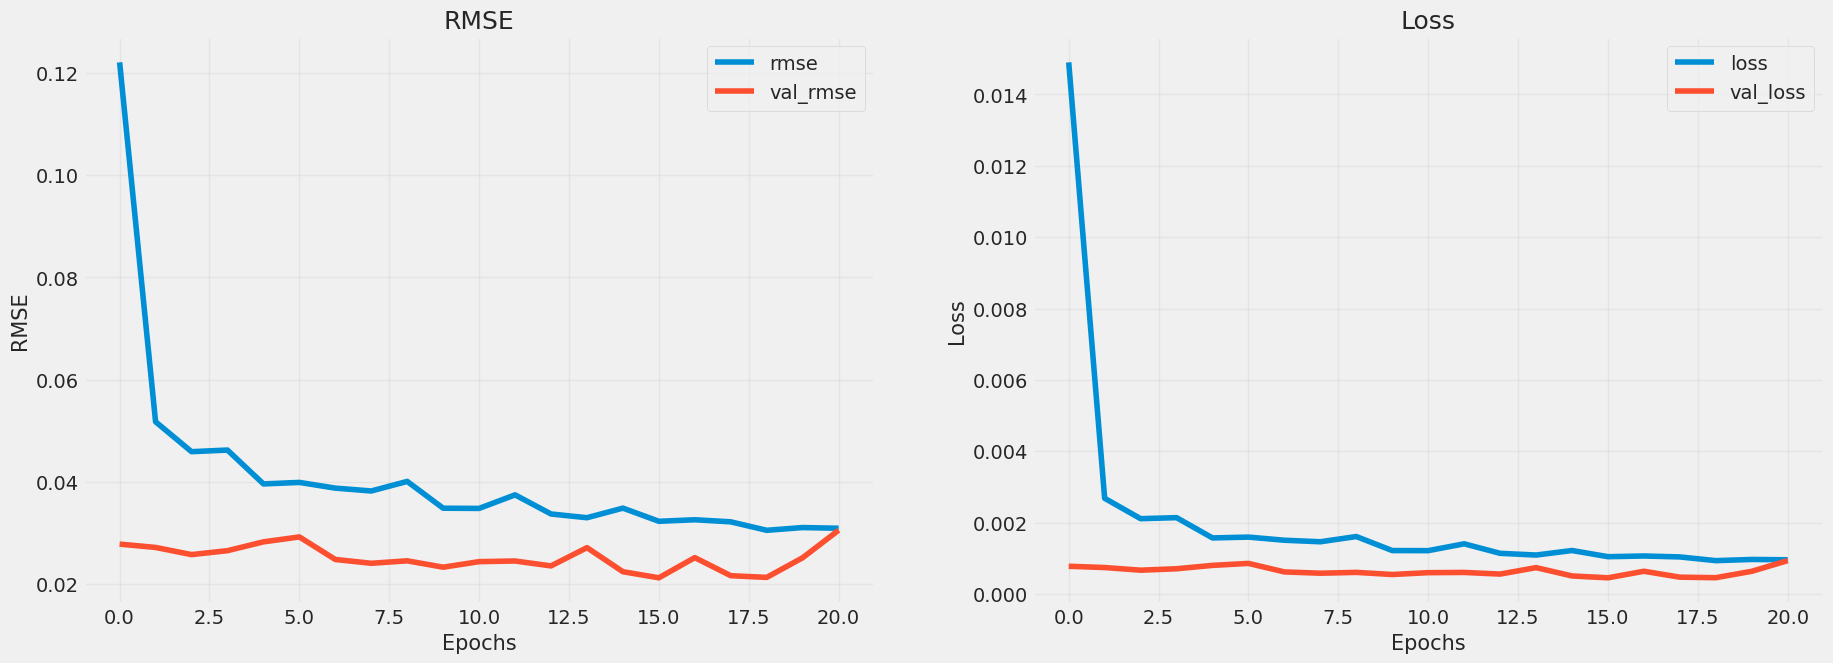

In [ ]:
fig = plt.figure(figsize=(20,7))
fig.add_subplot(121)

# Accuracy
plt.plot(history2.epoch, history2.history['root_mean_squared_error'], label = "rmse")
plt.plot(history2.epoch, history2.history['val_root_mean_squared_error'], label = "val_rmse")

plt.title("RMSE", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("RMSE", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()


#Adding Subplot 1 (For Loss)
fig.add_subplot(122)

plt.plot(history2.epoch, history2.history['loss'], label="loss")
plt.plot(history2.epoch, history2.history['val_loss'], label="val_loss")

plt.title("Loss", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

<ipython-input-21-6f01bde5bd74>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


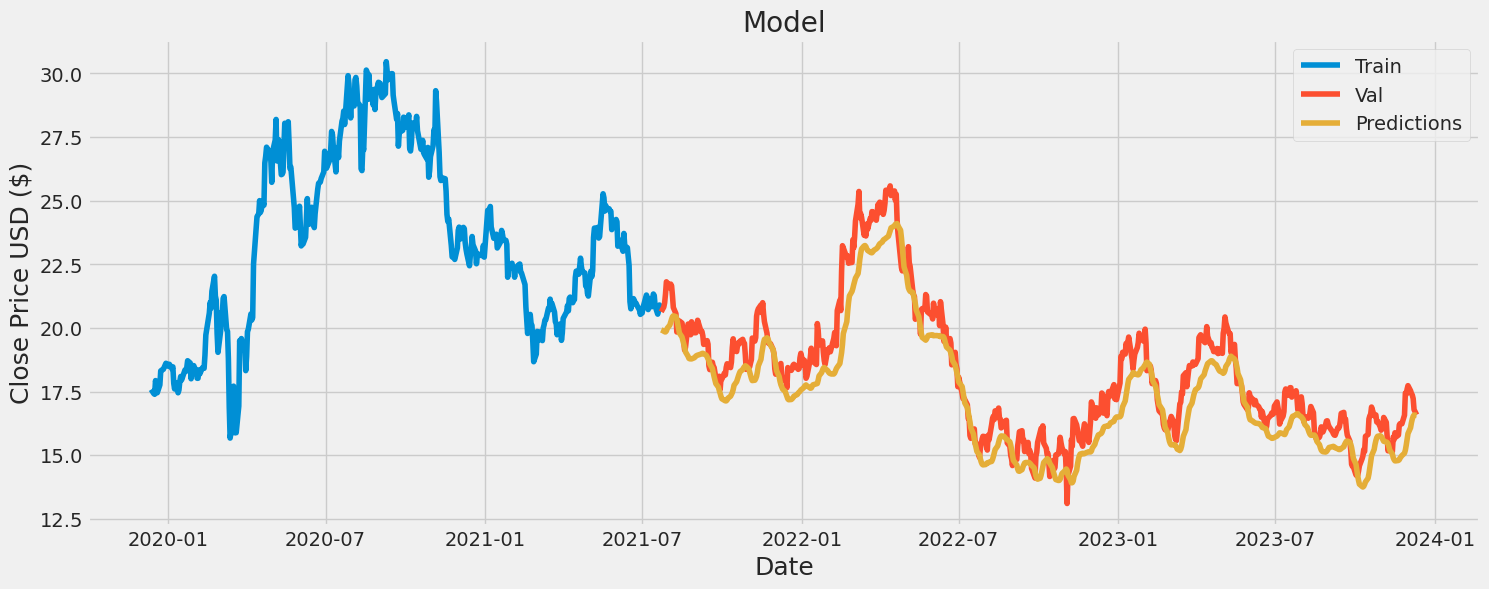

In [ ]:
# Plot the data
train = data[2000:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='upper right')
plt.show()

**Forcast Model 2**

In [ ]:
# generate the input and output sequences
n_lookback = 60  # length of input sequences (lookback period)
n_forecast =  252 * 5  # 5 years assuming about 252 trading days in a year
  # length of output sequences (forecast period)

X_fcast = []
Y_fcast = []

for i in range(n_lookback, len(scaled_data) - n_forecast + 1):
    X_fcast.append(scaled_data[i - n_lookback: i])
    Y_fcast.append(scaled_data[i: i + n_forecast])

X_fcast = np.array(X_fcast)
Y_fcast = np.array(Y_fcast)

In [ ]:
regressor1 = Sequential()
regressor1.add(LSTM(units=n_neurons1, return_sequences=True, input_shape=(n_lookback,1)))
regressor1.add(Dropout(dropout))
regressor1.add(LSTM(units=n_neurons2, return_sequences=False))
regressor1.add(Dropout(dropout))
regressor1.add(Dense(units=25))
regressor1.add(Dense(units=1,))
regressor1.add(Dense(n_forecast))
regressor1.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

file_path = 'best_model_fcast.h5'

mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

fhistory2 = regressor1.fit(X_fcast, Y_fcast, validation_split=0.2, epochs=40, batch_size=n_batch_size, callbacks=[es, mc], verbose=0)


Epoch 1: val_loss improved from inf to 0.07203, saving model to best_model_fcast.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 0.07203 to 0.04124, saving model to best_model_fcast.h5

Epoch 3: val_loss improved from 0.04124 to 0.02583, saving model to best_model_fcast.h5

Epoch 4: val_loss improved from 0.02583 to 0.02205, saving model to best_model_fcast.h5

Epoch 5: val_loss improved from 0.02205 to 0.02079, saving model to best_model_fcast.h5

Epoch 6: val_loss improved from 0.02079 to 0.01957, saving model to best_model_fcast.h5

Epoch 7: val_loss did not improve from 0.01957

Epoch 8: val_loss did not improve from 0.01957

Epoch 9: val_loss did not improve from 0.01957

Epoch 10: val_loss did not improve from 0.01957

Epoch 11: val_loss did not improve from 0.01957

Epoch 12: val_loss did not improve from 0.01957

Epoch 13: val_loss did not improve from 0.01957

Epoch 14: val_loss did not improve from 0.01957

Epoch 15: val_loss did not improve from 0.01957

Epoch 16: val_loss did not improve from 0.01957

Epoch 17: val_loss did not improve from 0.01957

Epoch 18: val_loss

In [ ]:
# generate the forecasts
X_ = scaled_data[- n_lookback:]  # last available input sequence
X_ = X_.reshape(1, n_lookback, 1)

Y_ = regressor1.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)

1/1 [==============================] - 1s 893ms/step


In [ ]:
# Extract actual values from the original DataFrame
actual_values = df['Close'].iloc[-n_forecast:].values.reshape(-1, 1)

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(actual_values, Y_))
print(f'Root Mean Squared Error (RMSE): {rmse}')

Root Mean Squared Error (RMSE): 6.7788042810330476


In [ ]:
# Calculate Mean Absolute Percentage Error (MAPE)
def calculate_mape(y_true, y_pred):
    assert len(y_true) == len(y_pred), "Input arrays must have the same length"
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate MAPE
mape = calculate_mape(actual_values, Y_)

print("Mean Absolute Percentage Error (MAPE): {:.2f}%".format(mape))


Mean Absolute Percentage Error (MAPE): 24.97%


In [ ]:
fhistory2.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

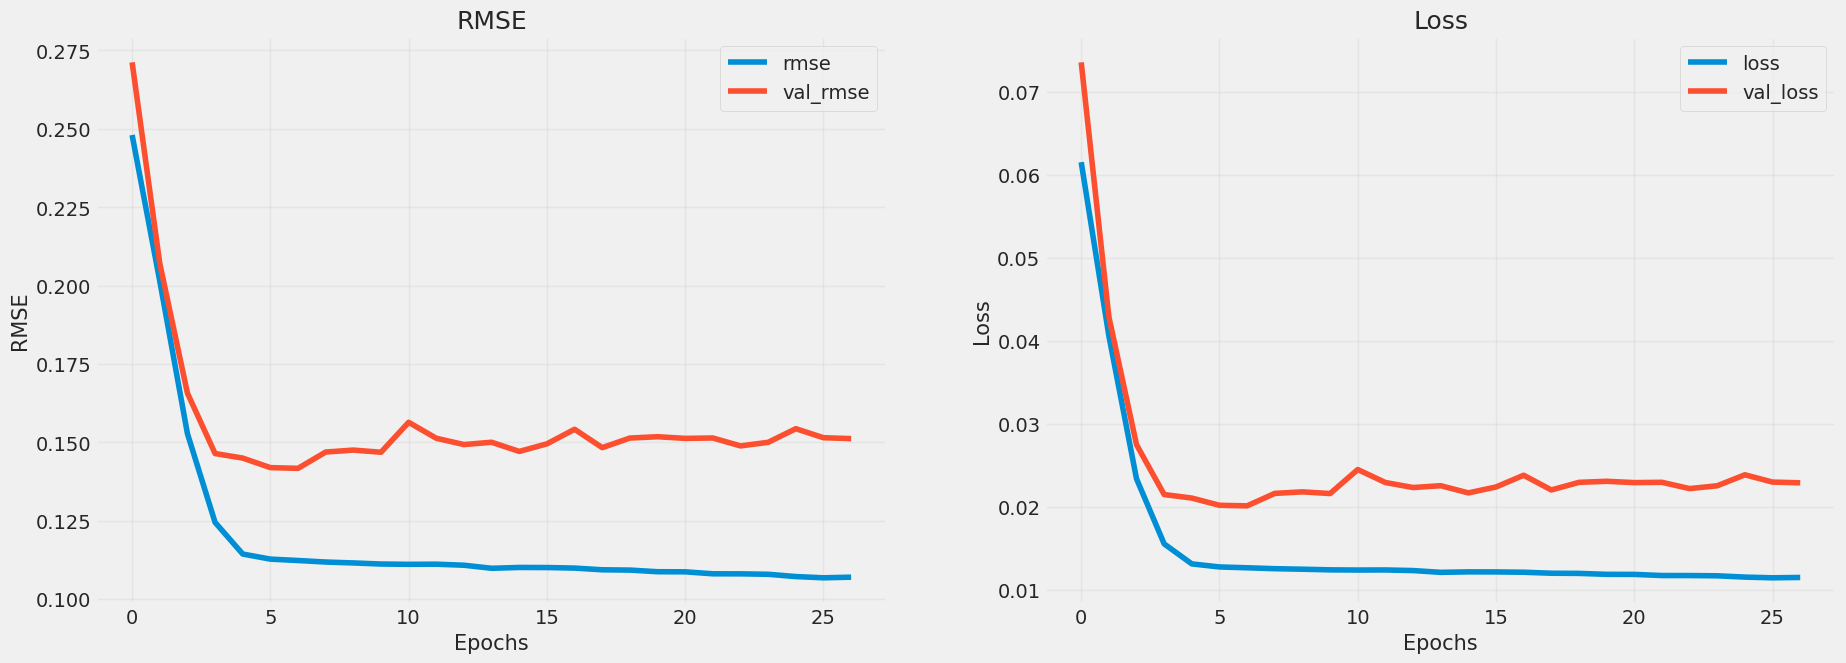

In [ ]:
fig = plt.figure(figsize=(20,7))
fig.add_subplot(121)

# Accuracy
plt.plot(fhistory2.epoch, fhistory2.history['root_mean_squared_error'], label = "rmse")
plt.plot(fhistory2.epoch, fhistory2.history['val_root_mean_squared_error'], label = "val_rmse")

plt.title("RMSE", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("RMSE", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()


#Adding Subplot 1 (For Loss)
fig.add_subplot(122)

plt.plot(fhistory2.epoch, fhistory2.history['loss'], label="loss")
plt.plot(fhistory2.epoch, fhistory2.history['val_loss'], label="val_loss")

plt.title("Loss", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

<ipython-input-27-8037592b10ea>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]
<ipython-input-27-8037592b10ea>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = df_past.append(df_future).set_index('Date')


<Axes: title={'center': 'GOLD'}, xlabel='Date'>

<Figure size 1600x600 with 0 Axes>

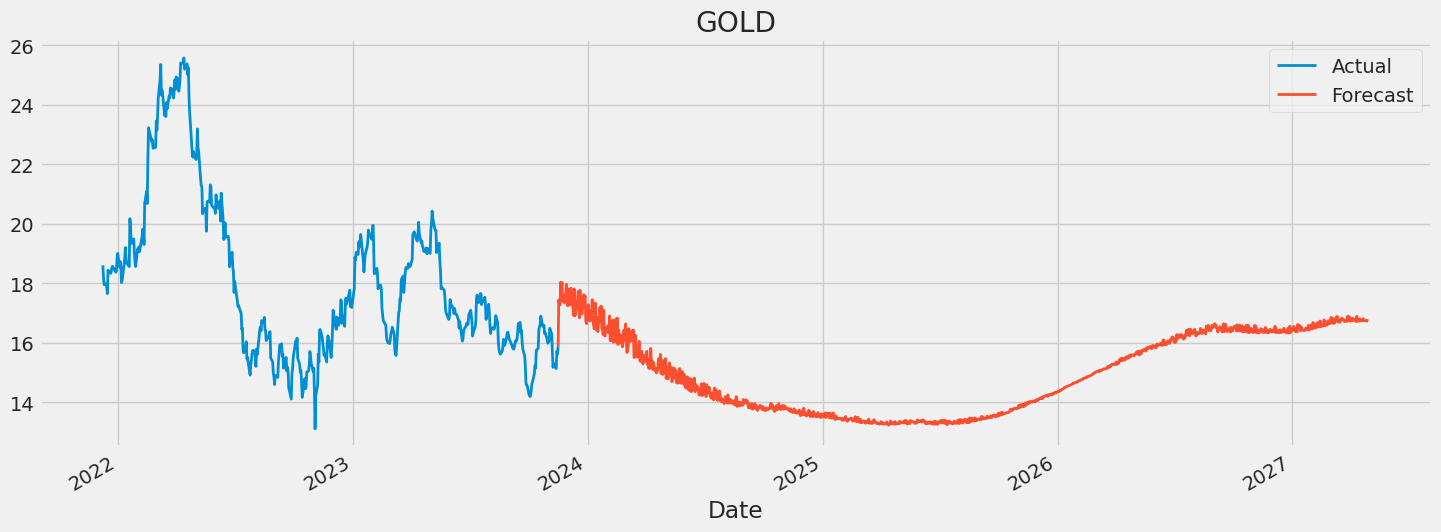

In [ ]:
data_zoom = data[2500:]
data_zoom.shape
# organize the results in a data frame
df_past = data_zoom[['Close']].reset_index()
df_past.rename(columns={'index': 'Date', 'Close': 'Actual'}, inplace=True)
df_past['Date'] = pd.to_datetime(df_past['Date'])
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_forecast)
df_future['Forecast'] = Y_.flatten()
df_future['Actual'] = np.nan

results = df_past.append(df_future).set_index('Date')

# plot the results
plt.figure(figsize=(16,6))
results.plot(title='GOLD', figsize=(16,6), linewidth = 2.0)